In [1]:
knitr::opts_chunk$set(echo = TRUE)

In [ ]:
knitr::opts_chunk$set(echo = TRUE)
library(panelvar)
library(plm)
library(glue)
library(ggplot2)
library(tseries)
library(tidyr)
library(urca)
library(vars)
library(aod)
library(zoo)
library(panelvar)
library(dplyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome to panelvar! Please cite our package in your publications -- see citation("panelvar")


Attaching package: ‘plm’


The following objects are masked from ‘package:dplyr’:

    between, lag, lead


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘tidyr’


The following object is masked from ‘package:panelvar’:

    extract


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: lmtest


Attaching pa

In [1]:
source('gmc_src/GMC.R')
source('gmc_src/Equality.R')

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



Warning message:
“no DISPLAY variable so Tk is not available”
Loading required package: sgeostat

This build of rgl does not include OpenGL functions.  Use
 rglwidget() to display results, e.g. via options(rgl.printRglwidget = TRUE).



# Word Sense GMC Application

## Preprocessing

Sanity check by randomizing word order- previously verified in word_sense_gmc.Rmd that we get the same gmc results across runs for different random seeds- we just have to ensure that we maintain consistent word ordering

1. Define our 3 kinds of measures - centrality, semantic diversity, frequency

2. Create a random word order and ensure this order is applied consistently across ALL metrics. For a given measure i in decade j, a word x should have the same position in that vector and a vector for a different measure k in decade j, or any other decade.

3. Group in decade dictionaries for ease of access

In [4]:
centrality_measures = c('betweenness', 'closeness', 'clusterrank',
    'constraint', 'degree', 'diffusion','dmnc',
    'hubs', 'laplacian', 'lobby', 'mnc',
    'pagerank', 'topocoefficient', 'transitivity')

frequency_measures = c('zipf')


sd_measures = c('spectral_diversity', 'nonzero_eigenvalues', 'entropy', 'condition_number')

antonyms_df = read.csv("gmc_src/data/antonyms_with_network_properties.csv")
metrics_df = read.csv("gmc_src/data/words_metrics_long_df.csv")

set.seed(42)  # Set seed for reproducibility
#jitter_amount <- runif(nrow(metrics_df), min = -0.05, max = 0.05)
#metrics_df$nonzero_eigenvalues <- metrics_df$nonzero_eigenvalues + jitter_amount




random_word_order <- metrics_df %>%
  distinct(word) %>%
  mutate(rand = runif(n())) %>%
  arrange(rand) %>%
  dplyr::select(word)

# 3. Join this random order back to 'metrics_df' and arrange by 'rand'
metrics_df_random <- metrics_df %>%
  inner_join(random_word_order %>% mutate(rand_order = row_number()), by = "word") %>%
  arrange(rand_order) %>%
  dplyr::select(-rand_order)

metrics_df$random_measure <- runif(nrow(metrics_df), min = 0, max = 1)

# Now 'metrics_df_random' has all rows for each word in a single, consistent random position

# ---- If you need a quick check:
head(metrics_df_random)

# 4. Create decade-based column dictionaries for original vs. randomized data
unique_decades <- unique(metrics_df$decade)
column_dicts_set <- list()

for (decade in unique_decades) {
  subset_df <- metrics_df[metrics_df$decade == decade, ]
  column_dict <- lapply(subset_df, as.list)
  names(column_dict) <- names(subset_df)
  column_dicts_set[[paste0("column_dict_", decade)]] <- column_dict
}

unique_decades_random <- unique(metrics_df_random$decade)
column_dicts_random_set <- list()

for (decade in unique_decades_random) {
  subset_df_random <- metrics_df_random[metrics_df_random$decade == decade, ]
  column_dict_random <- lapply(subset_df_random, as.list)
  names(column_dict_random) <- names(subset_df_random)
  column_dicts_random_set[[paste0("column_dict_", decade)]] <- column_dict_random
}

,word,decade,betweenness,closeness,clusterrank,constraint,degree,diffusion,dmnc,hubs,⋯,lobby,mnc,pagerank,topocoefficient,transitivity,zipf,spectral_diversity,nonzero_eigenvalues,entropy,condition_number
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,unfair,1820,0.000000e+00,0.3639409,253706.0,0.007618547,0.01231195,696536,2.834837,0.06114187,⋯,170,169,2.138588e-05,0.08573144,0.3643280,3.488814,32.74990,8,0.9711643,12.432673
2,unfair,1830,1.499128e-07,0.3813037,317123.4,0.003733816,0.02785141,1262140,2.641080,0.10894379,⋯,376,393,3.971524e-05,0.06105001,0.2513372,3.603549,23.67659,1,0.7179758,8.117734
3,unfair,1840,1.016882e-08,0.3775107,265778.0,0.005255401,0.01839638,917628,2.700407,0.07067368,⋯,256,258,2.474348e-05,0.06994123,0.2897174,3.541916,33.83945,8,1.0297058,9.949971
4,unfair,1850,9.907849e-08,0.3874331,339304.8,0.003965529,0.02428209,1270010,2.642094,0.08893477,⋯,340,345,2.652909e-05,0.06990127,0.2672396,3.578424,34.12160,8,1.1750026,10.769073
5,unfair,1860,5.371908e-08,0.3870199,309139.7,0.004490339,0.02180294,1111082,2.609272,0.08661712,⋯,309,311,2.568552e-05,0.06798322,0.2783114,3.686966,32.08530,6,0.9219049,11.853761
6,unfair,1870,3.808345e-07,0.3884816,339477.2,0.003697384,0.02686940,1311792,2.542953,0.09779340,⋯,383,386,2.747297e-05,0.06368256,0.2588655,3.795260,43.97454,7,1.2599971,16.157654


In [5]:
length(unique(metrics_df$word))

[1] 350

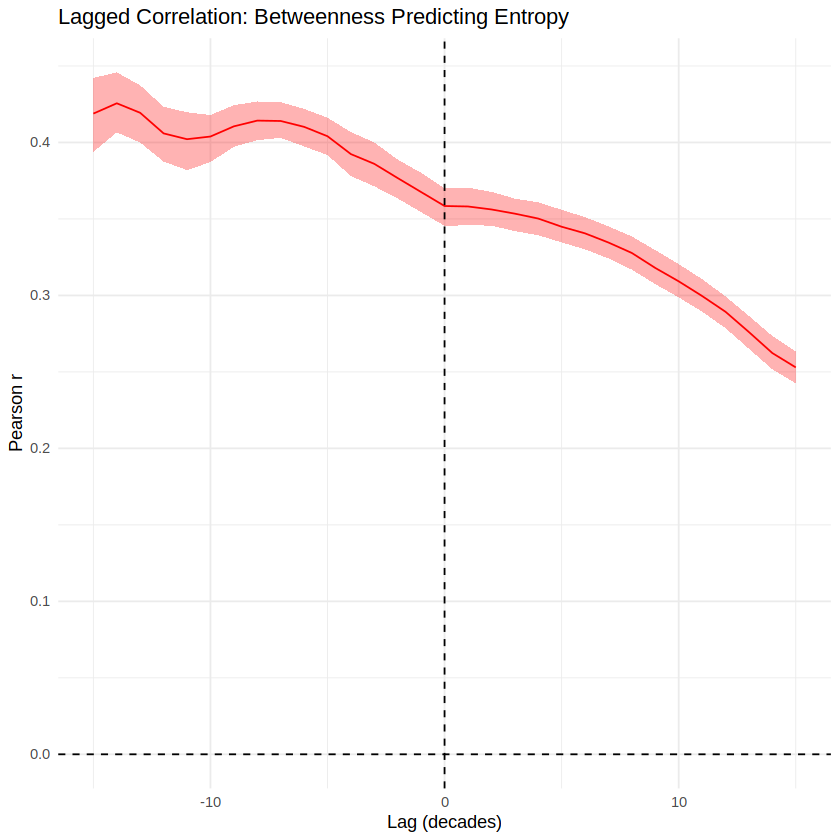

In [43]:
library(dplyr)
library(ggplot2)
library(purrr)
library(broom)

lags <- -15:15
lag_results <- list()

for (lag_val in lags) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(lag_val)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    }

  corr_df <- tmp %>%
  filter(
    !is.na(betweenness_shifted) & !is.na(entropy),
    sd(betweenness_shifted) > 0,
    sd(entropy) > 0
  ) %>%
  summarise(
    r = if (n() > 1) cor(betweenness_shifted, entropy, use = "complete.obs") else NA_real_
  ) %>%
  mutate(lag = lag_val)


  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (unchanged)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$betweenness_shifted) == 0 || sd(sample_data$entropy) == 0) {
      NA
    } else {
      cor(sample_data$betweenness_shifted, sample_data$entropy, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop (already correct)
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (lag_val > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = lag_val))
      } else if (lag_val < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(lag_val)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    } %>%
    filter(!is.na(betweenness_shifted) & !is.na(entropy))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'red') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'red', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Betweenness Predicting Entropy',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_line()`).”


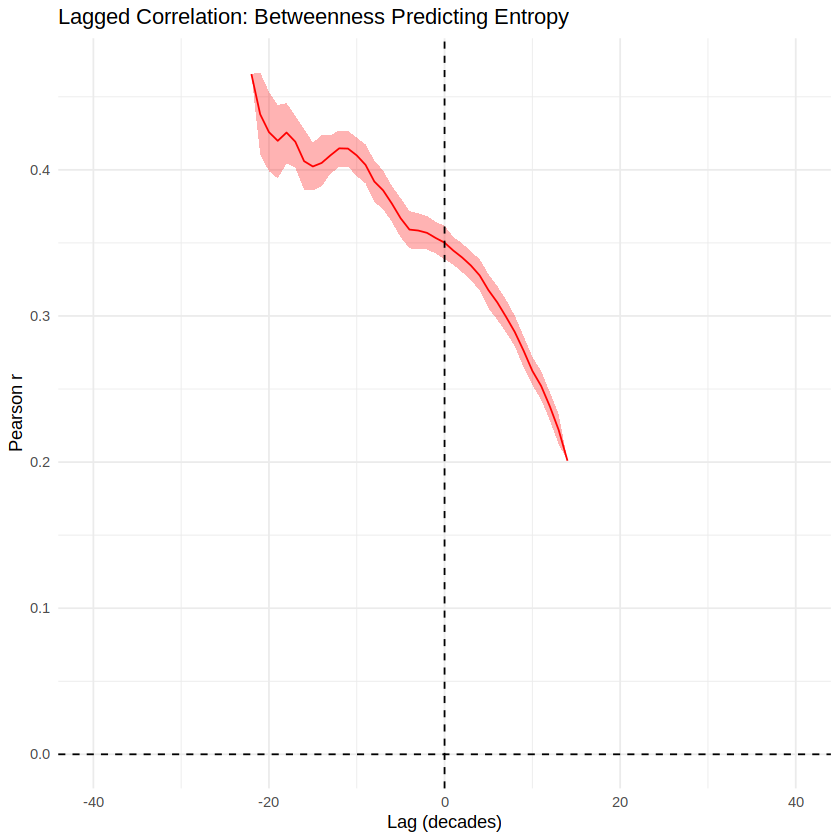

In [44]:
library(dplyr)
library(ggplot2)
library(purrr)
library(broom)

# Expand the lag range
lags <- -40:40
lag_results <- list()

for (lag_val in lags) {
  # Shift every lag by +4 to lag behind by 4 decades extra
  actual_lag <- lag_val + 4
  
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(actual_lag)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    }

  corr_df <- tmp %>%
    filter(
      !is.na(betweenness_shifted) & !is.na(entropy),
      sd(betweenness_shifted) > 0,
      sd(entropy) > 0
    ) %>%
    summarise(
      r = if (n() > 1) cor(betweenness_shifted, entropy, use = "complete.obs") else NA_real_
    ) %>%
    mutate(lag = lag_val)  # keep the original lag on the x-axis

  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (unchanged)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$betweenness_shifted) == 0 || sd(sample_data$entropy) == 0) {
      NA
    } else {
      cor(sample_data$betweenness_shifted, sample_data$entropy, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop with -40:40 lags, same logic
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  actual_lag <- lag_val + 4  # shift by 4
  
  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(actual_lag)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    } %>%
    filter(!is.na(betweenness_shifted) & !is.na(entropy))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'red') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'red', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Betweenness Predicting Entropy',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_line()`).”


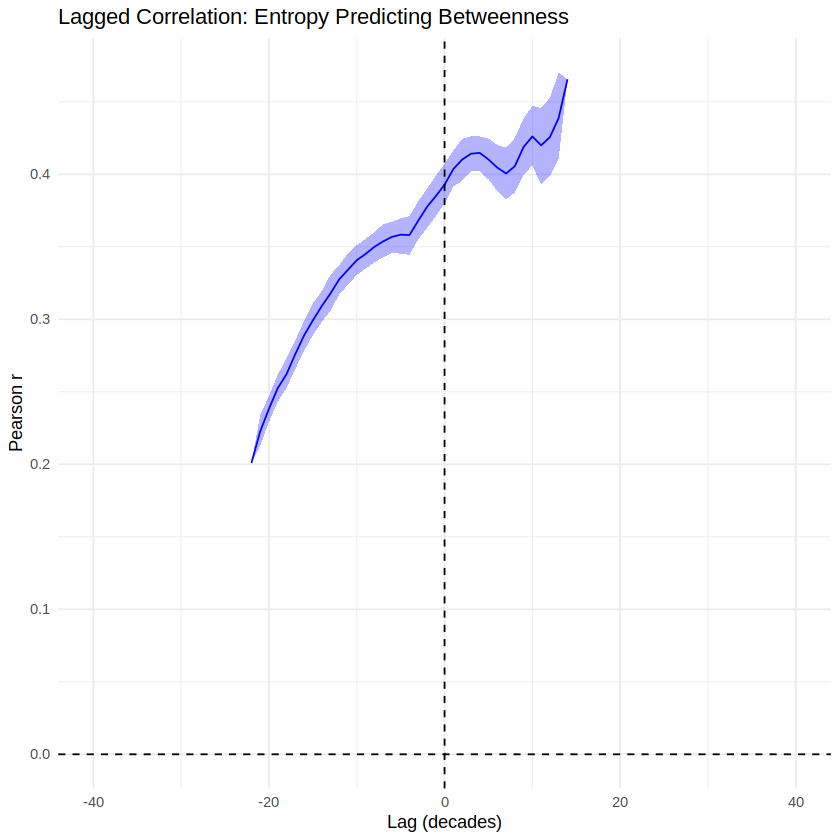

In [45]:
library(dplyr)
library(ggplot2)
library(purrr)
library(broom)

lags <- -40:40
lag_results <- list()

for (lag_val in lags) {
  actual_lag <- lag_val + 4  # shift by +4 decades

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., entropy_shifted = dplyr::lag(entropy, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., entropy_shifted = dplyr::lead(entropy, n = abs(actual_lag)))
      } else {
        mutate(., entropy_shifted = entropy)
      }
    }

  corr_df <- tmp %>%
    filter(
      !is.na(entropy_shifted) & !is.na(betweenness),
      sd(entropy_shifted) > 0,
      sd(betweenness) > 0
    ) %>%
    summarise(
      r = if (n() > 1) cor(entropy_shifted, betweenness, use = "complete.obs") else NA_real_
    ) %>%
    mutate(lag = lag_val)

  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (unchanged except for flipped vars)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$entropy_shifted) == 0 || sd(sample_data$betweenness) == 0) {
      NA
    } else {
      cor(sample_data$entropy_shifted, sample_data$betweenness, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop with flipped vars
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  actual_lag <- lag_val + 4  # shift by +4

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., entropy_shifted = dplyr::lag(entropy, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., entropy_shifted = dplyr::lead(entropy, n = abs(actual_lag)))
      } else {
        mutate(., entropy_shifted = entropy)
      }
    } %>%
    filter(!is.na(entropy_shifted) & !is.na(betweenness))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'blue') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'blue', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Entropy Predicting Betweenness',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_line()`).”


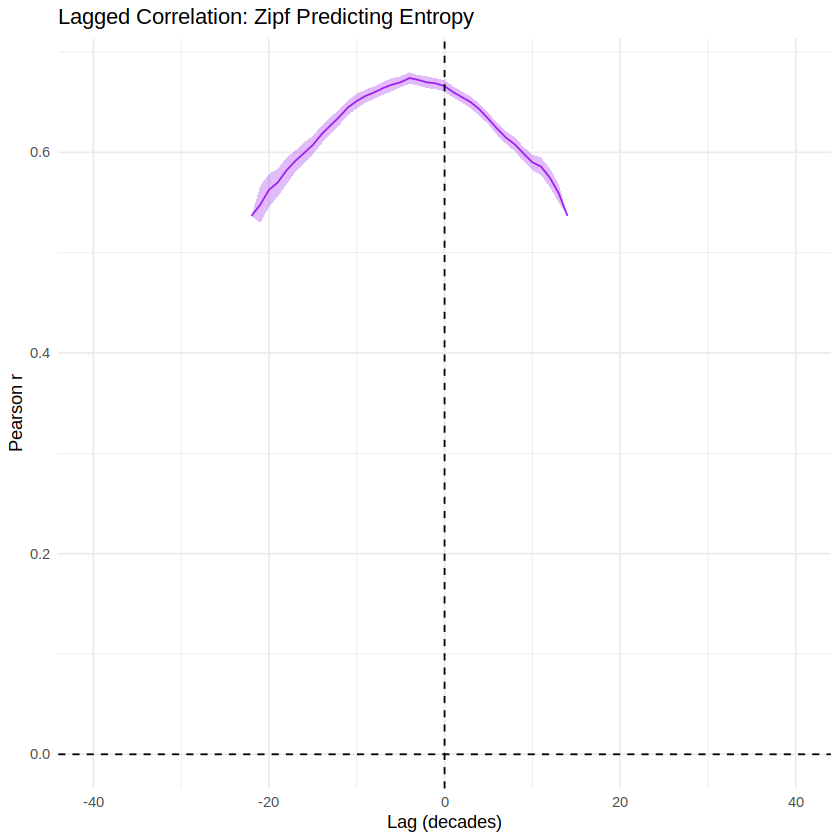

In [46]:
library(dplyr)
library(ggplot2)
library(purrr)
library(broom)

lags <- -40:40
lag_results <- list()

for (lag_val in lags) {
  actual_lag <- lag_val + 4  # shift by +4 decades

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., zipf_shifted = dplyr::lag(zipf, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., zipf_shifted = dplyr::lead(zipf, n = abs(actual_lag)))
      } else {
        mutate(., zipf_shifted = zipf)
      }
    }

  corr_df <- tmp %>%
    filter(
      !is.na(zipf_shifted) & !is.na(entropy),
      sd(zipf_shifted) > 0,
      sd(entropy) > 0
    ) %>%
    summarise(
      r = if (n() > 1) cor(zipf_shifted, entropy, use = "complete.obs") else NA_real_
    ) %>%
    mutate(lag = lag_val)

  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (swapped to zipf vs entropy)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$zipf_shifted) == 0 || sd(sample_data$entropy) == 0) {
      NA
    } else {
      cor(sample_data$zipf_shifted, sample_data$entropy, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop with Zipf vs Entropy
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  actual_lag <- lag_val + 4  # shift by +4

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., zipf_shifted = dplyr::lag(zipf, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., zipf_shifted = dplyr::lead(zipf, n = abs(actual_lag)))
      } else {
        mutate(., zipf_shifted = zipf)
      }
    } %>%
    filter(!is.na(zipf_shifted) & !is.na(entropy))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'purple') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'purple', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Zipf Predicting Entropy',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_line()`).”


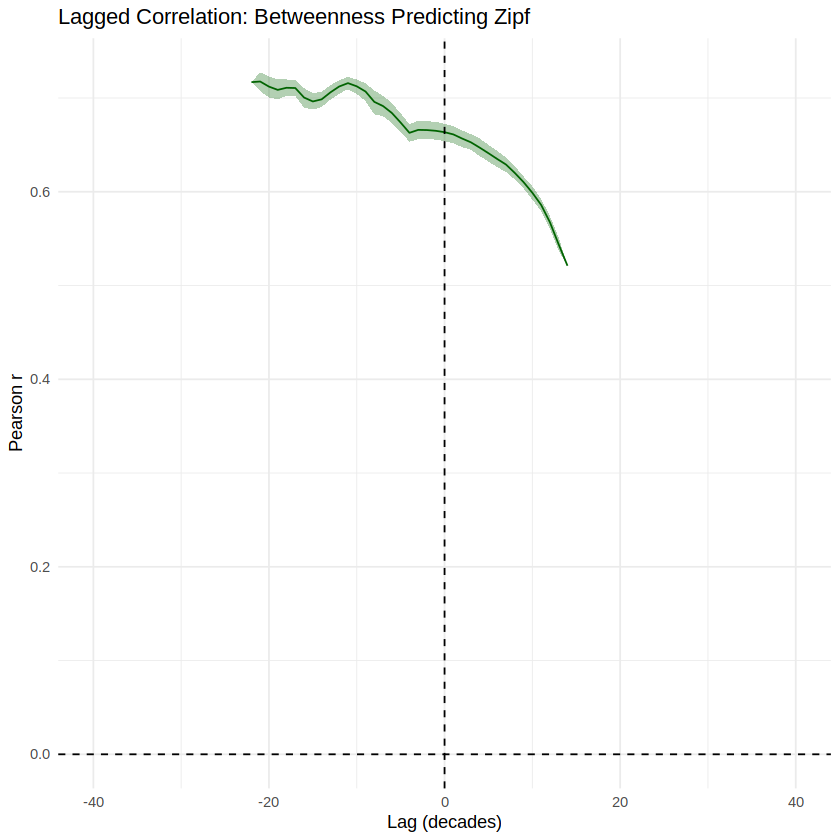

In [47]:
library(dplyr)
library(ggplot2)
library(purrr)
library(broom)

lags <- -40:40
lag_results <- list()

for (lag_val in lags) {
  actual_lag <- lag_val + 4  # keeping the +4 shift if you still want that

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(actual_lag)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    }

  corr_df <- tmp %>%
    filter(
      !is.na(betweenness_shifted) & !is.na(zipf),
      sd(betweenness_shifted) > 0,
      sd(zipf) > 0
    ) %>%
    summarise(
      r = if (n() > 1) cor(betweenness_shifted, zipf, use = "complete.obs") else NA_real_
    ) %>%
    mutate(lag = lag_val)

  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function (updated to zipf)
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$betweenness_shifted) == 0 || sd(sample_data$zipf) == 0) {
      NA
    } else {
      cor(sample_data$betweenness_shifted, sample_data$zipf, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  actual_lag <- lag_val + 4  # keeping the +4 shift

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., betweenness_shifted = dplyr::lag(betweenness, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., betweenness_shifted = dplyr::lead(betweenness, n = abs(actual_lag)))
      } else {
        mutate(., betweenness_shifted = betweenness)
      }
    } %>%
    filter(!is.na(betweenness_shifted) & !is.na(zipf))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_line(color = 'darkgreen') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'darkgreen', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Betweenness Predicting Zipf',
    x = 'Lag (decades)',
    y = 'Pearson r'
  ) +
  theme_minimal()


Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 44 rows containing missing values or values outside the scale range
(`geom_line()`).”


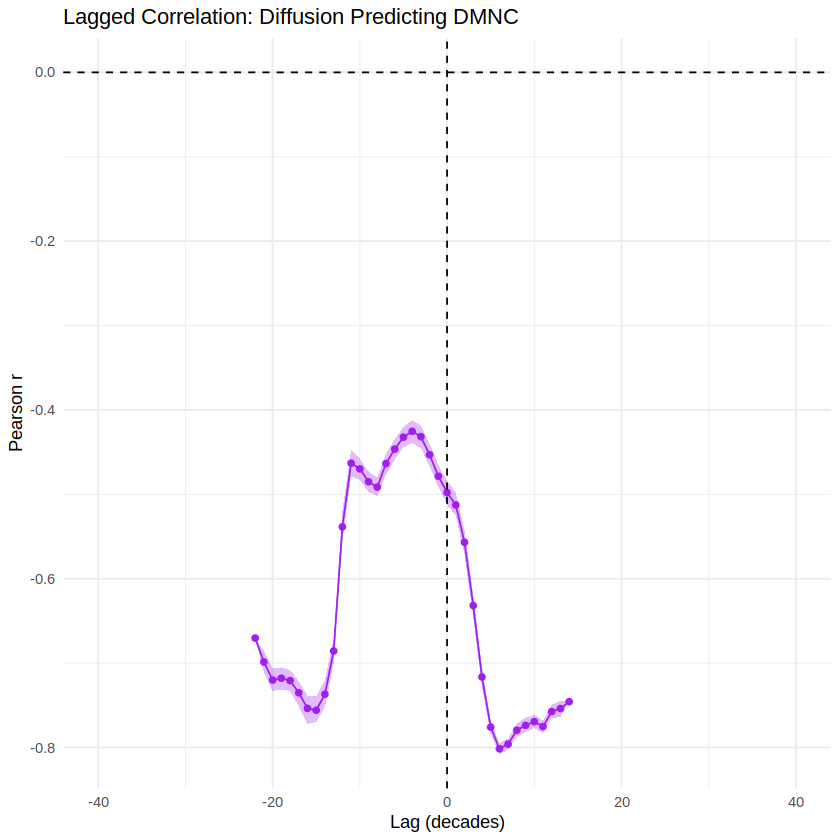

In [48]:
library(dplyr)
library(ggplot2)
library(purrr)
library(broom)

lags <- -40:40
lag_results <- list()

for (lag_val in lags) {
  actual_lag <- lag_val + 4  # shift by +4 decades if you want that offset

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., diffusion_shifted = dplyr::lag(diffusion, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., diffusion_shifted = dplyr::lead(diffusion, n = abs(actual_lag)))
      } else {
        mutate(., diffusion_shifted = diffusion)
      }
    }

  corr_df <- tmp %>%
    filter(
      !is.na(diffusion_shifted) & !is.na(dmnc),
      sd(diffusion_shifted) > 0,
      sd(dmnc) > 0
    ) %>%
    summarise(
      r = if (n() > 1) cor(diffusion_shifted, dmnc, use = "complete.obs") else NA_real_
    ) %>%
    mutate(lag = lag_val)

  lag_results[[as.character(lag_val)]] <- corr_df
}

all_lags_df <- bind_rows(lag_results)

# Bootstrap function
bootstrap_corr <- function(data, lag, n_boot = 500) {
  boot_rs <- replicate(n_boot, {
    sample_data <- data %>% sample_frac(replace = TRUE)
    if (sd(sample_data$diffusion_shifted) == 0 || sd(sample_data$dmnc) == 0) {
      NA
    } else {
      cor(sample_data$diffusion_shifted, sample_data$dmnc, use = "complete.obs")
    }
  })
  tibble(
    lag = lag,
    r = mean(boot_rs, na.rm = TRUE),
    ci_low = quantile(boot_rs, 0.025, na.rm = TRUE),
    ci_high = quantile(boot_rs, 0.975, na.rm = TRUE)
  )
}

# Bootstrap loop
bootstrap_results <- purrr::map_dfr(lags, function(lag_val) {
  actual_lag <- lag_val + 4  # keep same +4 shift if needed

  tmp <- metrics_df_random %>%
    group_by(word) %>%
    arrange(decade) %>%
    {
      if (actual_lag > 0) {
        mutate(., diffusion_shifted = dplyr::lag(diffusion, n = actual_lag))
      } else if (actual_lag < 0) {
        mutate(., diffusion_shifted = dplyr::lead(diffusion, n = abs(actual_lag)))
      } else {
        mutate(., diffusion_shifted = diffusion)
      }
    } %>%
    filter(!is.na(diffusion_shifted) & !is.na(dmnc))

  if (nrow(tmp) > 3) {
    bootstrap_corr(tmp, lag_val)
  } else {
    tibble(lag = lag_val, r = NA, ci_low = NA, ci_high = NA)
  }
})

# Plot: lag in decades (OR use lag * 10 for years if you want)
ggplot(bootstrap_results, aes(x = lag, y = r)) +
  geom_point(color = 'purple') +
  geom_line(color = 'purple') +
  geom_ribbon(aes(ymin = ci_low, ymax = ci_high), fill = 'purple', alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = 'dashed') +
  geom_vline(xintercept = 0, linetype = 'dashed') +
  labs(
    title = 'Lagged Correlation: Diffusion Predicting DMNC',
    x = 'Lag (decades)',  # or 'Lag (years)' if you multiply lag by 10
    y = 'Pearson r'
  ) +
  theme_minimal()


Sanity check to ensure we get the same values between the random and non random set...

In [6]:
gmcPvalue(unlist(column_dicts_random_set$column_dict_1860$laplacian), unlist(column_dicts_random_set$column_dict_1820$zipf), 0)


gmcPvalue(unlist(column_dicts_set$column_dict_1860$laplacian), unlist(column_dicts_set$column_dict_1820$zipf), 0)

[1]  8.420603e-13  0.000000e+00  0.000000e+00 -6.218779e-01  7.041790e-06

[1]  8.420603e-13  0.000000e+00  0.000000e+00 -6.218779e-01  7.041790e-06

## Computation

The specific GMC method does a nonparametric hypothesis test for pairwise dependence between some vector xxi and another vector yyi. The specific method uses kernel density estimation(Hlscv) to measure covariance between x and y.

For a measure j in decade i, and all other relevant(not-within category) measures k0...kn:

1. GMC(j_i|k_n_i), GMC(k_n_i | j_i), for all j and k in decade i. (within decade effects)

2. For decades i-q, where q is the lag:

GMC(j_i | k_n_(i-q)), GMC(k_n_(i-q) | j_i)

^TLDR we want to compute, for a given predicted y, the WITHIN DECADE relationships to all other measures and the LAGGED relationships to all other measures, in both directions.

In [7]:
compute_GMC <- function(measure_1, measure_2, decade_1, decade_2, input_dict) {
  # Build dictionary keys for the given decades
  dict_1 <- input_dict[[paste0("column_dict_", decade_1)]]
  dict_2 <- input_dict[[paste0("column_dict_", decade_2)]]

  if (is.null(dict_1) || is.null(dict_2)) {
    print(paste("Missing dictionary for:", decade_1, "or", decade_2))
    return(list(gmc_values = NULL, warning = "Missing dictionary"))
  }

  # Retrieve the correct columns using measure names
  xxi <- unlist(dict_1[[measure_1]])
  yyi <- unlist(dict_2[[measure_2]])

  if (is.null(xxi) || is.null(yyi) || length(xxi) == 0 || length(yyi) == 0) {
    print(paste("Missing or empty metric for:", measure_1, "or", measure_2, "in decades", decade_1, "or", decade_2))
    return(list(gmc_values = NULL, warning = "Empty metric"))
  }

  print(paste("Computing GMC for:", measure_1, decade_1, "vs.", measure_2, decade_2))

  # Compute GMC with error handling
  warning_log <- NULL
  out <- 0

  gmc_xy <- tryCatch(
    {
      withCallingHandlers(
        {
          gmcPvalue(xxi, yyi, out)
        },
        warning = function(w) {
          warning_log <<- conditionMessage(w)
          invokeRestart("muffleWarning")
        }
      )
    },
    error = function(e) {
      print("Computation failed, returning NULL")
      return(NULL)
    }
  )

  # Ensure the return is always a list
  return(list(gmc_values = gmc_xy, warning = warning_log))
}

In [8]:
centrality_measures = c('betweenness')

frequency_measures = c('zipf')


sd_measures = c('spectral_diversity', 'entropy')

In [28]:
decades <- c(1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000)
#decades = c(1820, 1830)
results <- list()

for (decade_1 in decades) {
  for (lag in c(1)) {  # Limit lags to +1, +2, +3 only
    decade_2 <- decade_1 + (lag * 10)
    if (!(decade_2 %in% decades)) next  # Ensure decade_2 is valid

    for (measure_group_1 in list(centrality_measures, frequency_measures, sd_measures)) {
      for (measure_1 in measure_group_1) {
        for (measure_group_2 in list(centrality_measures, frequency_measures, sd_measures)) {
          for (measure_2 in measure_group_2) {

            # Skip within-group comparisons for different measures
            if (identical(measure_group_1, measure_group_2) && measure_1 != measure_2) next

            # Compute the GMC value
            gmc_result <- compute_GMC(measure_1, measure_2, decade_1, decade_2, column_dicts_random_set)

          # Extract GMC values and warning
            denote1 <- gmc_result$gmc_values[1]
            denote2 <- gmc_result$gmc_values[2]
            pvalue <- gmc_result$gmc_values[3]
            t1 <- gmc_result$gmc_values[4]
            t2 <- gmc_result$gmc_values[5]

            warning <- gmc_result$warning


            key <- paste(measure_1, decade_1, "~", measure_2, decade_2, sep = "_")

            results[[key]] <- list(
              denote1 = denote1,
              denote2 = denote2,
              pvalue = pvalue,
              warning = warning,
              t1 = t1,
              t2 = t2
            )

            # Print details for debugging
            print(key)
            print(paste("denote1:", denote1))
            print(paste("denote2:", denote2))
            print(paste("pvalue:", pvalue))
            print(paste("t1:", t1))
            print(paste("t2:", t2))
            if (!is.null(warning)) print(paste("warning:", warning))
            print("-----------")

          }
        }
      }
    }
  }
}

# Access results
print(results)

[1] "Computing GMC for: betweenness 1820 vs. betweenness 1830"
[1] "betweenness_1820_~_betweenness_1830"
[1] "denote1: 0.784877653382569"
[1] "denote2: 0.800843087490361"
[1] "pvalue: 0.613644490487153"
[1] "t1: -0.122295670068978"
[1] "t2: -0.126128420905938"
[1] "warning: Data contain duplicated values: LSCV is not well-behaved in this case"
[1] "-----------"
[1] "Computing GMC for: betweenness 1820 vs. zipf 1830"
[1] "betweenness_1820_~_zipf_1830"
[1] "denote1: 0.99"
[1] "denote2: 0.605949152471523"
[1] "pvalue: 0"
[1] "t1: -0.487720059585035"
[1] "t2: -5.39325165152725e-12"
[1] "warning: Data contain duplicated values: LSCV is not well-behaved in this case"
[1] "-----------"
[1] "Computing GMC for: betweenness 1820 vs. spectral_diversity 1830"
[1] "betweenness_1820_~_spectral_diversity_1830"
[1] "denote1: 0.99"
[1] "denote2: 0.411435633561817"
[1] "pvalue: 0"
[1] "t1: -0.499148887050529"
[1] "t2: -4.22282967854724e-12"
[1] "-----------"
[1] "Computing GMC for: betweenness 1820 vs. 

## Plot relationships

In [29]:
plotEffectSizeByDecade <- function(results, response_measure, response_decade, p_cut) {

  # 1. Identify relevant keys in the results dictionary
  pattern_suffix <- paste0("_~_", response_measure, "_", response_decade)

  # Find keys where response_measure and response_decade match the input
  valid_keys <- names(results)[
    grepl(pattern_suffix, names(results), fixed = TRUE)
  ]

  if (length(valid_keys) == 0) {
    message("No matching keys found for predictors predicting ", response_measure, " in ", response_decade)
    return(invisible(NULL))
  }

  # 2. Extract relevant data: predictor measure, predictor decade, effect size, and p-value
  predictors_df <- data.frame(
    predictor_measure = character(),
    predictor_decade  = numeric(),
    effect_size       = numeric(),
    p_value           = numeric(),
    stringsAsFactors  = FALSE
  )

  for (k in valid_keys) {
    val <- results[[k]]

    # Ensure the value list contains all required components
    if (is.null(val$denote1) || is.null(val$denote2) || is.null(val$pvalue)) next

    # Ensure denote1 and denote2 are numeric and not NA
    if (!is.numeric(val$denote1) || !is.numeric(val$denote2) || is.na(val$denote1) || is.na(val$denote2)) next

    # *** Only proceed if denote1 > denote2 ***
    if (val$denote1 <= val$denote2) next

    # Effect size is simply denote1 here
    effect_size <- val$denote1

    p_value <- val$pvalue
    if (is.null(p_value) || is.na(p_value)) next
    if (p_value == 0) next
    if (!is.null(val$warning)) next

    # Parse predictor measure and decade from the key
    split_on_tilde <- strsplit(k, "_~_")[[1]]
    predictor_info <- strsplit(split_on_tilde[1], "_")[[1]]

    predictor_measure <- paste0(predictor_info[-length(predictor_info)], collapse = "_")
    predictor_decade  <- as.numeric(predictor_info[length(predictor_info)])

    # Include predictor decades <= response decade and p-values below threshold
    if (predictor_decade <= as.numeric(response_decade) && p_value < p_cut && predictor_measure != "nonzero_eigenvalues") {
      predictors_df <- rbind(
        predictors_df,
        data.frame(
          predictor_measure = predictor_measure,
          predictor_decade  = predictor_decade,
          effect_size       = effect_size,
          p_value           = p_value,
          stringsAsFactors  = FALSE
        )
      )
    }
  }

  # If no valid predictors remain, stop
  if (nrow(predictors_df) == 0) {
    message("No predictors passed p-value threshold (p < ", p_cut, ") with denote1 > denote2 for decades <= ", response_decade)
    return(invisible(NULL))
  }

  # 3. Plot the data
  ggplot(predictors_df, aes(x = factor(predictor_decade), y = effect_size, fill = predictor_measure)) +
    geom_bar(stat = "identity", position = "dodge") +
    theme_minimal() +
    labs(
      title = paste0("Predictors of ", response_measure, " in ", response_decade),
      x = "Predictor Decade",
      y = "Effect Size (denote1 > denote2 only)",
      fill = "Predictor Measure"
    ) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

In [11]:
centrality_measures = c('betweenness', 'closeness', 'clusterrank',
    'constraint', 'degree', 'diffusion','dmnc',
    'hubs', 'laplacian', 'lobby', 'mnc',
    'pagerank', 'topocoefficient', 'transitivity')

frequency_measures = c('zipf')


sd_measures = c('spectral_diversity','entropy', 'condition_number')

In [35]:
install.packages("ggplot")

Warning message:
“package ‘ggplot’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


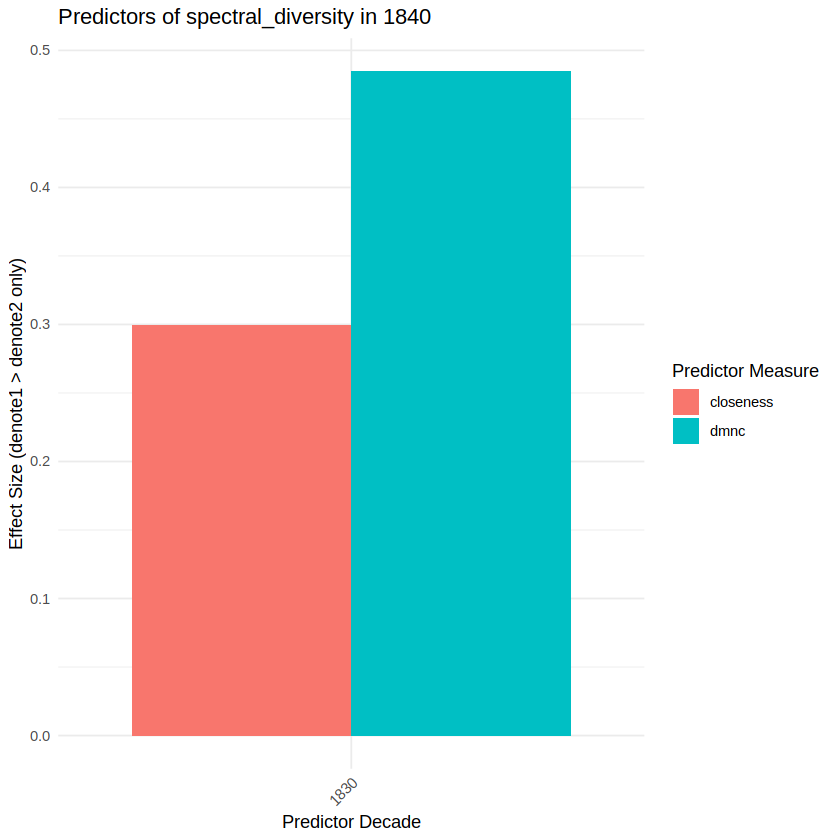

In [36]:
plotEffectSizeByDecade(results, "spectral_diversity", 1840, 0.05)

In [30]:
plotMultipleMeasuresForwardRelationships <- function(
  results,
  x_measures,  # vector of measure names for the bottom axis
  y_measures,  # vector of measure names for the top axis
  p_cut   = 0.05
) {
  #-------------------------------------------------
  # 1) Define the decades + numeric positions
  #-------------------------------------------------
  #decades <- c(1820, 1830, 1840, 1850, 1860,
  #             1870, 1880, 1890, 1900, 1910,
  #             1920, 1930, 1940, 1950, 1960,
  #             1970, 1980, 1990, 2000)
  N <- length(decades)

  # Offsets for bottom row (x_measures)
  numX <- length(x_measures)
  x_offsets <- seq(-0.1 * (numX - 1), 0.1 * (numX - 1), length.out = numX)
  names(x_offsets) <- x_measures

  # Offsets for top row (y_measures)
  numY <- length(y_measures)
  y_offsets <- seq(-0.1 * (numY - 1), 0.1 * (numY - 1), length.out = numY)
  names(y_offsets) <- y_measures

  #-------------------------------------------------
  # 2) Build a data frame for bottom (x_measures) and top (y_measures)
  #-------------------------------------------------
  bottom_points <- data.frame(
    measure = character(),
    decade  = numeric(),
    x       = numeric(),
    y       = numeric(),
    stringsAsFactors = FALSE
  )
  top_points <- data.frame(
    measure = character(),
    decade  = numeric(),
    x       = numeric(),
    y       = numeric(),
    stringsAsFactors = FALSE
  )

  for (i in seq_along(decades)) {
    d <- decades[i]
    for (xm in x_measures) {
      bottom_points <- rbind(
        bottom_points,
        data.frame(
          measure = xm,
          decade  = d,
          x       = i + x_offsets[xm],  # center i plus offset
          y       = 0,                  # bottom row
          stringsAsFactors = FALSE
        )
      )
    }
    for (ym in y_measures) {
      top_points <- rbind(
        top_points,
        data.frame(
          measure = ym,
          decade  = d,
          x       = i + y_offsets[ym],  # center i plus offset
          y       = 1,                  # top row
          stringsAsFactors = FALSE
        )
      )
    }
  }

  # Combine
  point_data <- rbind(bottom_points, top_points)

  # Build a lookup key => (x, y)
  point_data$key <- paste0(point_data$measure, "_", point_data$decade)
  coords_lookup <- setNames(
    lapply(seq_len(nrow(point_data)), function(idx) {
      c(point_data$x[idx], point_data$y[idx])
    }),
    point_data$key
  )

  #-------------------------------------------------
  # 3) Parse `results` for forward p < p_cut, p != 0,
  #    no warnings, and store effect_size
  #-------------------------------------------------
  edges_df <- data.frame(
    x1          = numeric(),
    y1          = numeric(),
    x2          = numeric(),
    y2          = numeric(),
    effect_size = numeric(),
    stringsAsFactors = FALSE
  )

  getDecade <- function(part) {
    bits <- strsplit(part, "_")[[1]]
    as.numeric(tail(bits, 1))
  }
  getMeasure <- function(part) {
    bits <- strsplit(part, "_")[[1]]
    paste(head(bits, -1), collapse = "_")
  }

  for (k in names(results)) {
    val <- results[[k]]
    # Basic checks
    if (is.null(val$denote1) || is.null(val$denote2) || is.null(val$pvalue)) next
    if (!is.numeric(val$denote1) || !is.numeric(val$denote2)) next
    if (is.na(val$denote1) || is.na(val$denote2)) next
    if (is.na(val$pvalue) || val$pvalue >= p_cut) next
    if (val$pvalue == 0) next
    if (!is.null(val$warning)) next

    # Determine effect_size by largest absolute
    eff_size <- val$denote1
    if (abs(val$denote2) > abs(val$denote1)) {
      eff_size <- val$denote2
    }

    parts <- strsplit(k, "_~_")[[1]]
    if (length(parts) != 2) next
    left_side  <- parts[1]
    right_side <- parts[2]

    left_decade   <- getDecade(left_side)
    left_measure  <- getMeasure(left_side)
    right_decade  <- getDecade(right_side)
    right_measure <- getMeasure(right_side)

    # Only consider decades we track
    if (!(left_decade  %in% decades)) next
    if (!(right_decade %in% decades)) next

    # Forward in time
    if (left_decade >= right_decade) next

    # Must be in x_measures or y_measures
    if (!(left_measure  %in% c(x_measures, y_measures))) next
    if (!(right_measure %in% c(x_measures, y_measures))) next

    keyL <- paste0(left_measure, "_", left_decade)
    keyR <- paste0(right_measure, "_", right_decade)

    if (! (keyL %in% names(coords_lookup))) next
    if (! (keyR %in% names(coords_lookup))) next

    xyL <- coords_lookup[[keyL]]
    xyR <- coords_lookup[[keyR]]

    edges_df <- rbind(edges_df, data.frame(
      x1 = xyL[1],
      y1 = xyL[2],
      x2 = xyR[1],
      y2 = xyR[2],
      effect_size = eff_size,
      stringsAsFactors = FALSE
    ))
  }

  if (nrow(edges_df) == 0) {
    message("No forward relationships to plot under these conditions.")
    return(invisible(NULL))
  }

  #-------------------------------------------------
  # 4) Build the ggplot with separate "fill" for points
  #    (discrete scale) and "color" for arrows
  #    (continuous scale).
  #-------------------------------------------------

  # Our x scale: 1..N across the decades
  bottom_breaks <- seq_len(N)
  bottom_labels <- decades
  top_breaks    <- seq_len(N)
  top_labels    <- decades

  p <- ggplot() +
    # Points: use shape=21 so we can fill with measure (discrete)
    geom_point(
      data = point_data,
      aes(x = x, y = y, fill = measure),
      shape = 21,         # circle w/ fill
      color = "black",    # outline
      size = 3
    ) +
    # Edges: use color= effect_size (continuous).
    # Must set 'inherit.aes=FALSE' so it doesn't pick up fill= measure from above.
    geom_segment(
      data = edges_df,
      aes(x = x1, y = y1, xend = x2, yend = y2, color = effect_size),
      arrow = arrow(length = unit(0.25, "cm"), type = "closed"),
      alpha = 0.8,
      inherit.aes = FALSE
    ) +

    # Discrete fill scale for measure (the points)
    scale_fill_discrete(name = "Measure") +

    # Continuous color scale for effect_size (the arrows)
    scale_color_gradient(low = "yellow", high = "red", name = "Effect Size") +

    scale_x_continuous(
      breaks = bottom_breaks,
      labels = bottom_labels,
      name   = "Decade (Bottom Axis)",
      sec.axis = dup_axis(name = "Decade (Top Axis)")
    ) +
    scale_y_continuous(
      limits = c(-0.2, 1.2),
      breaks = c(0, 1),
      labels = c("X row", "Y row")
    ) +
    labs(
      title = paste0(
        "Forward Relationships (p<", p_cut, ", p!=0) \nX=[",
        paste(x_measures, collapse=", "), "] vs. Y=[",
        paste(y_measures, collapse=", "), "]"
      )
    ) +
    theme_minimal() +
    theme(
      axis.text.x.bottom = element_text(angle=45, hjust=1),
      axis.text.x.top    = element_text(angle=45, hjust=0),
      panel.grid.minor   = element_blank()
    )

  print(p)
  invisible(p)
}

In [17]:
plotMultipleMeasuresForwardRelationships(
  results      = results,   # your GMC results list
  x_measures   = c("spectral_diversity"),     # multiple "bottom" measures
  y_measures   = c("betweenness", "dmnc"),     # multiple "top" measures
  p_cut        = 0.05     # significance threshold
)

No forward relationships to plot under these conditions.



In [20]:
plotAggregatedNetworkEffectSize <- function(results,
                                            measures = c("spectral_diversity", "zipf", "betweenness"),
                                            p_cut = 0.05,
                                            lag = 10,
                                            direction = "denote1_gt") {
  # Define decades of interest.
  decades <- c(1820, 1830, 1840, 1850, 1860,
               1870, 1880, 1890, 1900, 1910,
               1920, 1930, 1940, 1950, 1960,
               1970, 1980, 1990, 2000)

  # Create an empty list to collect qualifying edges.
  edges_list <- list()

  # Helper functions to parse a key part (e.g., "spectral_diversity_1820")
  getDecade <- function(side_string) {
    parts <- strsplit(side_string, "_")[[1]]
    as.numeric(tail(parts, 1))
  }
  getMeasure <- function(side_string) {
    parts <- strsplit(side_string, "_")[[1]]
    paste(head(parts, -1), collapse = "_")
  }

  # Loop over each key in results.
  for (k in names(results)) {
    val <- results[[k]]

    # Skip if required fields are missing or if p is not significant.
    if (is.null(val$denote1) || is.null(val$denote2) || is.null(val$pvalue)) next
    if (!is.numeric(val$denote1) || !is.numeric(val$denote2)) next
    if (is.na(val$denote1) || is.na(val$denote2)) next
    if (is.na(val$pvalue) || val$pvalue >= p_cut) next
    if (val$pvalue == 0) next
    if (!is.null(val$warning)) next

    # *** Apply direction filter ***
    if (direction == "denote1_gt" && val$denote1 <= val$denote2) next  # Skip if denote1 is NOT greater than denote2
    if (direction == "denote2_gt" && val$denote1 >= val$denote2) next  # Skip if denote2 is NOT greater than denote1

    # Use denote1 as the effect size when denote1 > denote2, otherwise denote2
    eff_size <- if (direction == "denote1_gt") val$denote1 else val$denote2

    # Parse the key into left and right sides.
    parts <- strsplit(k, "_~_")[[1]]
    if (length(parts) != 2) next
    left_side  <- parts[1]
    right_side <- parts[2]

    left_decade   <- getDecade(left_side)
    right_decade  <- getDecade(right_side)
    left_measure  <- getMeasure(left_side)
    right_measure <- getMeasure(right_side)

    # Only consider decades we track.
    if (!(left_decade %in% decades)) next
    if (!(right_decade %in% decades)) next

    # Keep only relationships spanning exactly the specified lag.
    if (right_decade != left_decade + lag) next

    # Only keep if both measures are in our specified set.
    if (!(left_measure %in% measures)) next
    if (!(right_measure %in% measures)) next

    # Record this relationship.
    edges_list[[length(edges_list) + 1]] <- data.frame(
      predictor  = left_measure,
      predicted  = right_measure,
      effect_size = eff_size,
      stringsAsFactors = FALSE
    )
  }

  # If no qualifying relationships were found, report and exit.
  if (length(edges_list) == 0) {
    message("No significant n+lag relationships found where ",
            ifelse(direction == "denote1_gt", "denote1 > denote2", "denote2 > denote1"),
            ".")
    return(invisible(NULL))
  }

  # Combine all collected rows.
  edges_df <- do.call(rbind, edges_list)

  # Aggregate (average) effect sizes for each predictor → predicted pair.
  agg_df <- aggregate(effect_size ~ predictor + predicted, data = edges_df, FUN = mean)

  # Create a directed graph using igraph.
  if (!requireNamespace("igraph", quietly = TRUE)) {
    stop("Package 'igraph' is required for this function.")
  }
  library(igraph)

  g <- graph_from_data_frame(agg_df, directed = TRUE, vertices = measures)

  # Set edge attributes.
  E(g)$effect_size <- agg_df$effect_size

  # Map the effect size to a width between 1 and 5.
  abs_vals <- abs(E(g)$effect_size)
  scaled_width <- if (max(abs_vals) > 0) {
    1 + 4 * (abs_vals / max(abs_vals))
  } else {
    rep(1, length(E(g)))
  }
  E(g)$width <- scaled_width

  # Color edges: red for positive effect sizes, blue for negative.
  E(g)$color <- ifelse(E(g)$effect_size > 0, "red", "blue")

  # Label edges with the rounded effect size.
  E(g)$label <- round(E(g)$effect_size, 2)
  E(g)$label.cex <- 1.2
  E(g)$label.color <- "black"

  # Set vertex attributes for a better look.
  V(g)$size <- 50
  V(g)$color <- "skyblue"
  V(g)$frame.color <- "white"
  V(g)$label.color <- "black"
  V(g)$label.cex <- 1.5

  # Choose a force-directed layout for a more organic appearance.
  lay <- layout_nicely(g)

  # Plot the graph.
  plot(g,
       layout = lay,
       edge.arrow.size = 0.8,
       edge.curved = 0.4,
       main = paste0("Aggregated Average Significant Effect Size\n(n+", lag/10, " decade predictions, ",
                     ifelse(direction == "denote1_gt", "denote1 > denote2", "denote2 > denote1"), ")"),
       vertex.label.dist = 1.2)

  title(sub = "Arrow width ~ average |effect size|; red = positive, blue = negative", cex.sub = 1.2)
}

In [21]:
my_measures <- c("spectral_diversity", "zipf", "betweenness")
plotAggregatedNetworkEffectSize(results, measures = my_measures, p_cut = 0.05/4500, lag=10, direction="denote1_gt")

No significant n+lag relationships found where denote1 > denote2.



In [22]:
plotDirectionalEffectsAll <- function(dataAll,
                                      measureVec = c("spectral_diversity", "zipf", "betweenness"),
                                      pCut = 0.05,
                                      lagNum = 10) {
  ########################
  # Helper function: Remove trailing year from measure names
  getShortMeasureName <- function(varName) {
    partsSplitted <- strsplit(varName, "_")[[1]]
    paste(head(partsSplitted, -1), collapse = "_")
  }

  # Extract decade from measure name
  getDecadeVal <- function(varName) {
    partsSplitted <- strsplit(varName, "_")[[1]]
    as.numeric(tail(partsSplitted, 1))
  }

  ########################
  # Create collector for directional effects (x -> y)
  effectCollector <- list()

  # Also, we store raw data for verification
  rawData <- list()

  ########################
  # Iterate over dataAll
  for (recordKey in names(dataAll)) {
    recordData <- dataAll[[recordKey]]

    # -- Strict Filtering for Valid Entries --
    if (is.null(recordData[["pVal"]]) ||
        !is.numeric(recordData[["pVal"]]) ||
        length(recordData[["pVal"]]) != 1 ||
        is.na(recordData[["pVal"]]) ||
        recordData[["pVal"]] == 0) {
      next
    }

    # Must be significant
    if (recordData[["pVal"]] >= pCut) next

    # Check val1 and val2
    if (is.null(recordData[["val1"]]) || is.null(recordData[["val2"]])) next
    if (!is.numeric(recordData[["val1"]]) || !is.numeric(recordData[["val2"]])) next
    if (any(is.na(c(recordData[["val1"]], recordData[["val2"]])))) next

    ########################
    # Parse recordKey: Expected format "xVarFull_~_yVarFull"
    splittedKey <- strsplit(recordKey, "_~_")[[1]]
    if (length(splittedKey) != 2) next

    xVarFull <- splittedKey[1]
    yVarFull <- splittedKey[2]

    # Extract measure names and decades
    xVar     <- getShortMeasureName(xVarFull)
    yVar     <- getShortMeasureName(yVarFull)
    xDecade  <- getDecadeVal(xVarFull)
    yDecade  <- getDecadeVal(yVarFull)

    # Ensure both variables are in the target measureVec
    if (!(xVar %in% measureVec) || !(yVar %in% measureVec)) next

    # **Ensure the exact time lag is met**
    if (yDecade - xDecade != lagNum) next

    ########################
    # Create key for effectCollector
    keyPair <- paste(xVar, yVar, sep = "||")
    if (!keyPair %in% names(effectCollector)) {
      effectCollector[[keyPair]] <- list(den1 = numeric(0), den2 = numeric(0))
    }

    # Store **only significant** val1 or val2
    if (recordData[["pVal"]] < pCut) {
      if (recordData[["val1"]] > recordData[["val2"]]) {
        effectCollector[[keyPair]]$den1 <- c(effectCollector[[keyPair]]$den1, recordData[["val1"]])
      } else {
        effectCollector[[keyPair]]$den2 <- c(effectCollector[[keyPair]]$den2, recordData[["val2"]])
      }
    }

    # Store raw record for verification
    rawData[[length(rawData) + 1]] <- data.frame(
      x_var    = xVar,
      y_var    = yVar,
      x_decade = xDecade,
      y_decade = yDecade,
      val1     = recordData[["val1"]],
      val2     = recordData[["val2"]],
      pVal     = recordData[["pVal"]],
      chosenVal= ifelse(recordData[["val1"]] > recordData[["val2"]], "val1", "val2"),
      stringsAsFactors = FALSE
    )
  } # End main loop

  ########################
  # If no valid relationships, exit
  if (length(effectCollector) == 0) {
    message("No significant directional relationships found among the specified measures with lag =", lagNum)
    return(invisible(NULL))
  }

  ########################
  # Print raw data table
  rawTableData <- do.call(rbind, rawData)
  message("\n=== RAW SIGNIFICANT RELATIONSHIPS TABLE (Lag =", lagNum, ") ===\n")
  print(rawTableData)

  ########################
  # Compute final effect size for each pair (x -> y)
  edgeList <- list()
  for (pairItem in names(effectCollector)) {
    splittedPair <- strsplit(pairItem, "\\|\\|")[[1]]
    if (length(splittedPair) != 2) next
    Xval <- splittedPair[1]
    Yval <- splittedPair[2]

    # Compute average val1 and val2 (only using significant values)
    avgDen1 <- if (length(effectCollector[[pairItem]]$den1) > 0) {
      mean(effectCollector[[pairItem]]$den1)
    } else 0

    avgDen2 <- if (length(effectCollector[[pairItem]]$den2) > 0) {
      mean(effectCollector[[pairItem]]$den2)
    } else 0

    # Compute signed effect size
    finalEffect <- avgDen1 - avgDen2

    # Only add an edge if there's a real difference
    if (finalEffect != 0) {
      edgeList[[length(edgeList) + 1]] <- data.frame(
        from = Xval,
        to   = Yval,
        effect_size = finalEffect,
        stringsAsFactors = FALSE
      )
    }
  }

  # Combine into one dataframe
  edgeData <- do.call(rbind, edgeList)

  # Assign colors: Red for positive, Blue for negative
  edgeData$color <- ifelse(edgeData$effect_size > 0, "red", "blue")

  ########################
  # Apply curvature to avoid overlapping arrows
  edgeData$curve <- 0.3  # Slight curvature

  ########################
  # Build and visualize the graph using igraph
  if (!requireNamespace("igraph", quietly = TRUE)) {
    stop("Package 'igraph' is required for this function.")
  }
  library(igraph)

  # Create directed graph
  myGraph <- graph_from_data_frame(edgeData, directed = TRUE, vertices = measureVec)

  # Scale edge width by magnitude of effect
  absVals <- abs(edgeData$effect_size)
  scaledWidth <- if (max(absVals) > 0) {
    1 + 4 * (absVals / max(absVals))
  } else {
    rep(1, nrow(edgeData))
  }

  # Safely set edge attributes
  myGraph <- set_edge_attr(myGraph, "effect_size", value = edgeData$effect_size)
  myGraph <- set_edge_attr(myGraph, "color",       value = edgeData$color)
  myGraph <- set_edge_attr(myGraph, "curved",      value = edgeData$curve)
  myGraph <- set_edge_attr(myGraph, "width",       value = scaledWidth)
  myGraph <- set_edge_attr(myGraph, "label",       value = round(edgeData$effect_size, 2))
  myGraph <- set_edge_attr(myGraph, "label.cex",   value = 1.2)
  myGraph <- set_edge_attr(myGraph, "label.color", value = "black")

  # Safely set vertex attributes
  myGraph <- set_vertex_attr(myGraph, "size", value = 40)
  myGraph <- set_vertex_attr(myGraph, "color", value = "skyblue")
  myGraph <- set_vertex_attr(myGraph, "frame.color", value = "white")
  myGraph <- set_vertex_attr(myGraph, "label.color", value = "black")
  myGraph <- set_vertex_attr(myGraph, "label.cex",   value = 1.5)

  ########################
  # Plot the graph
  layoutPos <- layout_with_fr(myGraph)
  plot(
    myGraph,
    layout = layoutPos,
    edge.arrow.size = 0.8,
    main = paste0("Directional Effects (Lag = ", lagNum),
    vertex.label.dist = 1.2
  )

  title(sub = "Red = positive (val1 > val2), Blue = negative", cex.sub = 1.1)

  invisible(list(raw_table = rawTableData, graph = myGraph, edges = edgeData))
}

In [23]:
plotDirectionalEffectNetwork <- function(results,
                                         measures = c("spectral_diversity", "zipf", "betweenness"),
                                         p_cut = 0.05,
                                         lag_n = 10,
                                         export = FALSE,   # Enable/disable export
                                         export_format = "svg",  # Choose: "svg", "pdf", or "eps"
                                         file_name = "network_plot") {

  ########################
  # Helper function: Remove trailing year from measure names
  getMeasureName <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    paste(head(parts, -1), collapse = "_")
  }

  # Extract decade from measure name
  getDecade <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    as.numeric(tail(parts, 1))
  }

  # Initialize raw_df before using it
 # Initialize raw_df before using it
  raw_df <- data.frame(
    x_var = character(),
    y_var = character(),
    x_decade = numeric(),
    y_decade = numeric(),
    denote1 = numeric(),
    denote2 = numeric(),
    t1 = numeric(),
    t2 = numeric(),
    pvalue = numeric(),
    chosen = character(),
    stringsAsFactors = FALSE
  )

  ########################
  # Create aggregator for directional effects
  aggregator <- list()
  raw_records <- list()

  ########################
  # Iterate over results
  for (k in names(results)) {
    val <- results[[k]]


    # Strict filtering for valid entries
    if (!is.null(val$warning) && val$warning != "" && !is.na(val$warning) && !is.nan(val$warning)) next
    if (is.null(val$pvalue) || !is.numeric(val$pvalue) || is.na(val$pvalue) || val$pvalue >= p_cut) next
    if (is.null(val$denote1) || is.null(val$denote2) || any(is.na(c(val$denote1, val$denote2)))) next

    # Parse key: Expected format "x_var_full_~_y_var_full"
    parts_key <- strsplit(k, "_~_")[[1]]
    if (length(parts_key) != 2) next

    x_var_full <- parts_key[1]
    y_var_full <- parts_key[2]

    # Extract measure names and decades
    x_var <- getMeasureName(x_var_full)
    y_var <- getMeasureName(y_var_full)
    x_decade <- getDecade(x_var_full)
    y_decade <- getDecade(y_var_full)

    # Ensure both variables are in the target measures list
    if (!(x_var %in% measures) || !(y_var %in% measures)) next

    # Ensure the exact time lag is met
    if (y_decade - x_decade != lag_n) next

    # Create key for aggregator
    key_pair <- paste(x_var, y_var, sep = "||")
    if (!key_pair %in% names(aggregator)) {
      aggregator[[key_pair]] <- list(diff = numeric(0), t1_vals = numeric(0), t2_vals = numeric(0))
    }

    # Store **pairwise** denote1 - denote2 values along with t1, t2
    aggregator[[key_pair]]$diff <- c(aggregator[[key_pair]]$diff, val$denote1 - val$denote2)
    aggregator[[key_pair]]$t1_vals <- c(aggregator[[key_pair]]$t1_vals, val$t1)
    aggregator[[key_pair]]$t2_vals <- c(aggregator[[key_pair]]$t2_vals, val$t2)

    raw_records[[length(raw_records) + 1]] <- data.frame(
      x_var    = x_var,
      y_var    = y_var,
      x_decade = x_decade,
      y_decade = y_decade,
      denote1  = val$denote1,
      denote2  = val$denote2,
      t1 = val$t1,
      t2 = val$t2,
      pvalue   = val$pvalue,
      chosen   = ifelse(val$denote1 > val$denote2, "denote1", "denote2"),
      stringsAsFactors = FALSE
    )
  }

  ########################
  # If no valid relationships, exit
  if (length(aggregator) == 0) {
    message("No significant directional relationships found with lag =", lag_n)
    return(invisible(NULL))
  }

  ########################
  # Create edges dataframe
  edge_list <- list()
  for (pair in names(aggregator)) {
    parts_pair <- strsplit(pair, "\\|\\|")[[1]]
    if (length(parts_pair) != 2) next
    X <- parts_pair[1]
    Y <- parts_pair[2]

    # Compute mean of the pairwise differences directly
    avg_diff <- mean(aggregator[[pair]]$diff, na.rm = TRUE)
    avg_t1 <- mean(aggregator[[pair]]$t1_vals, na.rm = TRUE)
    avg_t2 <- mean(aggregator[[pair]]$t2_vals, na.rm = TRUE)

    if (!is.na(avg_diff)) {  # Ensure we don't remove bidirectional strong effects
      edge_list[[length(edge_list) + 1]] <- data.frame(
        from = X,
        to   = Y,
        causal_diff = avg_diff,
        effect_size = ifelse(avg_diff > 0, avg_t1, avg_t2),
        stringsAsFactors = FALSE
      )
    }
  }

  edges_df <- do.call(rbind, edge_list)
  edges_df$color <- ifelse(edges_df$effect_size > 0, "red", "blue")

  ########################
  # Build and visualize the graph using igraph
  library(igraph)
  g <- graph_from_data_frame(edges_df, directed = TRUE, vertices = measures)
  E(g)$effect_size <- edges_df$effect_size
  E(g)$color <- edges_df$color
  E(g)$curved <- 1

  abs_vals <- abs(E(g)$effect_size)
  scaled_width <- if (max(abs_vals) > 0) {
    1 + 8 * (abs_vals / max(abs_vals))
  } else {
    rep(1, length(E(g)))
  }
  E(g)$width <- scaled_width
  E(g)$label <- paste0("T: ", round(edges_df$effect_size, 2))
  E(g)$label.cex <- 1.8  # Make labels larger
  E(g)$label.color <- "black"
  E(g)$label.dist <- 2.5  # Move numbers further to the side

  V(g)$size <- 80
  V(g)$color <- "skyblue"
  V(g)$frame.color <- "white"
  V(g)$label.color <- "black"
  V(g)$label.cex <- 1.6

  layout_pos <- layout_nicely(g) * 1
  plot(g, layout = layout_pos, edge.arrow.size = 1, edge.arrow.width = 1,
       main = paste0("Directional Effects (Lag = ", lag_n, ", Net Effect = avg(denote1 - denote2))"),
       vertex.label.dist = 1.8)
  title(sub = "Red = positive (avg(denote1 - denote2) > 0), Blue = negative", cex.sub = 1.3)

  return(invisible(list(raw_table = raw_df, graph = g, edges = edges_df)))
}

In [24]:
t = plotDirectionalEffectNetwork(results, c("spectral_diversity", "betweenness", "zipf"),1,150)

No significant directional relationships found with lag =150



In [25]:
sd_sub = c("spectral_diversity", "entropy", "condition_number")
centrality_sub = c("betweenness")
# Iterate over all combinations
for (centrality in centrality_measures) {
  for (sd in sd_sub) {
    measures <- c("zipf", centrality, sd)

    # Print progress

    # Run the function and capture results
    result <- plotDirectionalEffectNetwork(results, measures, 0.05/2500, 150)
    print(result)
  }
}

No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


No significant directional relationships found with lag =150



NULL


In [26]:
lags <- c(30, 100, 150)

for (lag_n in lags) {
  for (centrality in centrality_measures) {
    for (sd in sd_sub) {
      measures <- c("zipf", centrality, sd)

      # Print progress
      cat("\nProcessing lag:", lag_n, "for measures:", paste(measures, collapse=", "), "\n")

      # Run the function and capture results
      result <- plotDirectionalEffectNetwork(results, measures, 0.05/2015, lag_n)

      # If result is NULL, continue
      if (is.null(result)) next

      # Extract edges dataframe
      edges_df <- result$edges

      # Add lag column for reference
      edges_df$lag <- lag_n

      # Filter for A → B with positive causal_diff
      valid_pairs <- edges_df[edges_df$causal_diff > 0, c("from", "to", "causal_diff", "effect_size", "lag")]

      # Identify pairs that meet the criteria
      valid_filtered <- vector("list", nrow(valid_pairs))
      for (i in seq_len(nrow(valid_pairs))) {
        A <- valid_pairs$from[i]
        B <- valid_pairs$to[i]
        causal_AB <- valid_pairs$causal_diff[i]

        # Check if B → A exists with a negative causal_diff
        reverse_causal <- edges_df[edges_df$from == B & edges_df$to == A, ]
        if (nrow(reverse_causal) > 0) {
          reverse_causal_diff <- reverse_causal$causal_diff[1]

          # Condition: B → A must be negative but numerically less than A → B
          if (reverse_causal_diff < 0 && abs(reverse_causal_diff) < causal_AB) {
            valid_filtered[[i]] <- edges_df[edges_df$from == A & edges_df$to == B, ]
          }
        } else {
          # No B → A exists, automatically include A → B
          valid_filtered[[i]] <- edges_df[edges_df$from == A & edges_df$to == B, ]
        }
      }

      # Flatten the list and remove NULLs
      valid_filtered <- do.call(rbind, valid_filtered)

      # Sort by largest effect sizes
      if (!is.null(valid_filtered) && nrow(valid_filtered) > 0) {
        valid_filtered <- valid_filtered[order(-valid_filtered$effect_size), ]

        # Limit output to the top 20
        top_results <- head(valid_filtered, 20)

        cat("\nSignificant causal effects found for lag:", lag_n, "\n")

        # Print the full raw table output
        raw_table <- result  # Extract the raw table

        # Ensure the raw_table is not empty before modifying
        print(raw_table)

        # Stop further processing once the top 20 results are printed
        break
      }
    }
  }
}


Processing lag: 30 for measures: zipf, betweenness, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, betweenness, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, betweenness, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, closeness, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, closeness, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, closeness, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, clusterrank, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, clusterrank, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, clusterrank, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, constraint, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, constraint, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, constraint, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, degree, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, degree, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, degree, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, diffusion, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, diffusion, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, diffusion, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, dmnc, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, dmnc, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, dmnc, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, hubs, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, hubs, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, hubs, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, laplacian, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, laplacian, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, laplacian, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, lobby, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, lobby, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, lobby, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, mnc, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, mnc, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, mnc, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, pagerank, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, pagerank, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, pagerank, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, topocoefficient, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, topocoefficient, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, topocoefficient, condition_number 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, transitivity, spectral_diversity 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, transitivity, entropy 


No significant directional relationships found with lag =30




Processing lag: 30 for measures: zipf, transitivity, condition_number 


No significant directional relationships found with lag =30




Processing lag: 100 for measures: zipf, betweenness, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, betweenness, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, betweenness, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, closeness, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, closeness, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, closeness, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, clusterrank, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, clusterrank, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, clusterrank, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, constraint, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, constraint, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, constraint, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, degree, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, degree, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, degree, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, diffusion, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, diffusion, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, diffusion, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, dmnc, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, dmnc, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, dmnc, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, hubs, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, hubs, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, hubs, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, laplacian, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, laplacian, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, laplacian, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, lobby, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, lobby, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, lobby, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, mnc, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, mnc, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, mnc, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, pagerank, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, pagerank, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, pagerank, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, topocoefficient, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, topocoefficient, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, topocoefficient, condition_number 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, transitivity, spectral_diversity 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, transitivity, entropy 


No significant directional relationships found with lag =100




Processing lag: 100 for measures: zipf, transitivity, condition_number 


No significant directional relationships found with lag =100




Processing lag: 150 for measures: zipf, betweenness, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, betweenness, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, betweenness, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, closeness, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, closeness, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, closeness, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, clusterrank, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, clusterrank, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, clusterrank, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, constraint, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, constraint, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, constraint, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, degree, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, degree, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, degree, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, diffusion, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, diffusion, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, diffusion, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, dmnc, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, dmnc, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, dmnc, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, hubs, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, hubs, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, hubs, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, laplacian, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, laplacian, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, laplacian, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, lobby, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, lobby, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, lobby, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, mnc, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, mnc, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, mnc, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, pagerank, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, pagerank, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, pagerank, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, topocoefficient, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, topocoefficient, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, topocoefficient, condition_number 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, transitivity, spectral_diversity 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, transitivity, entropy 


No significant directional relationships found with lag =150




Processing lag: 150 for measures: zipf, transitivity, condition_number 


No significant directional relationships found with lag =150



In [27]:
if (!dir.exists("exports")) {
  dir.create("exports")
}

sd_sub = c("spectral_diversity", "entropy")
centrality_sub = c("betweenness", "lobby", "degree", "closeness")

# Iterate over all combinations
for (centrality in centrality_sub) {
  for (sd in sd_sub) {
    measures <- c("zipf", centrality, sd)

    # Generate dynamic filename based on centrality and sd
    file_name <- paste0("exports/network_", centrality, "_", sd)

    # Run the function with export enabled
    plotDirectionalEffectNetwork(results,
                                 measures,
                                 p_cut = 0.05/552,  # Keep p-values >= 0
                                 lag_n = 150,
                                 export = FALSE,
                                 export_format = "svg",
                                 file_name = file_name)

    # Print progress
    message("Exported: ", file_name, ".svg")
  }
}

No significant directional relationships found with lag =150

Exported: exports/network_betweenness_spectral_diversity.svg

No significant directional relationships found with lag =150

Exported: exports/network_betweenness_entropy.svg

No significant directional relationships found with lag =150

Exported: exports/network_lobby_spectral_diversity.svg

No significant directional relationships found with lag =150

Exported: exports/network_lobby_entropy.svg

No significant directional relationships found with lag =150

Exported: exports/network_degree_spectral_diversity.svg

No significant directional relationships found with lag =150

Exported: exports/network_degree_entropy.svg

No significant directional relationships found with lag =150

Exported: exports/network_closeness_spectral_diversity.svg

No significant directional relationships found with lag =150

Exported: exports/network_closeness_entropy.svg



In [23]:
# Define centrality and semantic diversity measures
centrality_measures <- c("betweenness", "closeness")
sd_measures = c("condition_number", "spectral_diversity", "entropy")

# Store effect sizes for comparison
sd_effect_sizes <- data.frame(sd_measure = character(),
                              centrality = character(),
                              avg_effect_size = numeric(),
                              stringsAsFactors = FALSE)

# Iterate over all SD measures while keeping centrality fixed
for (sd in sd_measures) {
  for (centrality in centrality_measures) {
    measures <- c("zipf", centrality, sd)

    # Print progress
    print(paste("Processing:", sd, "and", centrality))

    # Run the function and capture results
    result <- plotDirectionalEffectNetwork(results, measures, 1, 30)

    # Extract effect sizes
    if (!is.null(result$edges)) {
      avg_effect_size <- mean(abs(result$edges$effect_size))  # Mean absolute effect size

      # Store in dataframe
      sd_effect_sizes <- rbind(sd_effect_sizes, data.frame(sd_measure = sd,
                                                           centrality = centrality,
                                                           avg_effect_size = avg_effect_size))
    }
  }
}

# Sort by largest effect size
sd_effect_sizes <- sd_effect_sizes[order(-sd_effect_sizes$avg_effect_size), ]

# Print the top 2 SD measures
print("Top 2 semantic diversity measures with largest effect size:")
print(sd_effect_sizes[1:2, ])

In [24]:
plotDirectionalEffectTrends <- function(results,
                                       measures = c("spectral_diversity", "zipf", "betweenness"),
                                       p_cut = 0.05,
                                       lag_n = 10) {
  library(ggplot2)

  ########################
  # Helper function: Remove trailing year from measure names
  getMeasureName <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    paste(head(parts, -1), collapse = "_")
  }

  # Extract decade from measure name
  getDecade <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    as.numeric(tail(parts, 1))
  }

  ########################
  # Collect Data
  trend_data <- data.frame(
    x_var = character(),
    y_var = character(),
    decade = numeric(),
    effect_difference = numeric(),
    stringsAsFactors = FALSE
  )

  ########################
  # Iterate over results
  for (k in names(results)) {
    val <- results[[k]]

    # Strict filtering for valid entries
    if (!is.null(val$warning) && val$warning != "" && !is.na(val$warning) && !is.nan(val$warning)) next
    if (is.null(val$pvalue) || !is.numeric(val$pvalue) || is.na(val$pvalue) || val$pvalue >= p_cut) next
    if (is.null(val$denote1) || is.null(val$denote2) || any(is.na(c(val$denote1, val$denote2)))) next

    # Parse key: Expected format "x_var_full_~_y_var_full"
    parts_key <- strsplit(k, "_~_")[[1]]
    if (length(parts_key) != 2) next

    x_var_full <- parts_key[1]
    y_var_full <- parts_key[2]

    # Extract measure names and decades
    x_var <- getMeasureName(x_var_full)
    y_var <- getMeasureName(y_var_full)
    x_decade <- getDecade(x_var_full)
    y_decade <- getDecade(y_var_full)

    # Ensure both variables are in the target measures list
    if (!(x_var %in% measures) || !(y_var %in% measures)) next

    # Ensure the exact time lag is met
    if (y_decade - x_decade != lag_n) next

    # Compute effect difference
    effect_difference <- val$denote1 - val$denote2

    # Store in dataframe
    trend_data <- rbind(trend_data, data.frame(
      x_var = x_var,
      y_var = y_var,
      decade = x_decade,
      effect_difference = effect_difference
    ))
  }

  ########################
  # If no valid relationships, exit
  if (nrow(trend_data) == 0) {
    message("No significant directional relationships found with lag =", lag_n)
    return(invisible(NULL))
  }

  ########################
  # Plot the trends for each relation combination

  ggplot(trend_data, aes(x = decade, y = effect_difference, color = x_var)) +
    geom_line(size = 1) +
    geom_point(size = 2) +
    facet_wrap(~ interaction(x_var, y_var), scales = "free_y") +
    labs(
      title = "Directional Effect Differences Over Time",
      x = "Decade",
      y = "denote1 - denote2",
      color = "Predictor"
    ) +
    theme_minimal()
}

In [25]:
plotDirectionalEffectTrends(results, lag=120, p_cut=0.05)

In [26]:
computeDirectionalEffects <- function(results, measures, lag_n = 10, p_cut = 0.05) {
  if (length(measures) != 3) {
    stop("Please provide exactly three measures.")
  }

  ########################
  # Helper functions
  getMeasureName <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    paste(head(parts, -1), collapse = "_")
  }

  getDecade <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    as.numeric(tail(parts, 1))
  }

  ########################
  # Iterate over results and extract forward directional effects
  output_records <- list()

  for (k in names(results)) {
    val <- results[[k]]

    # Strict filtering for valid entries
    if (!is.null(val$warning) && val$warning != "" && !is.na(val$warning) && !is.nan(val$warning)) next
    if (is.null(val$pvalue) || !is.numeric(val$pvalue) || is.na(val$pvalue) || val$pvalue >= p_cut) next
    if (is.null(val$denote1) || is.null(val$denote2) || any(is.na(c(val$denote1, val$denote2)))) next
    if (val$denote1 <= val$denote2) next  # Filter where denote1 is not greater than denote2

    # Parse key: Expected format "x_var_full_~_y_var_full"
    parts_key <- strsplit(k, "_~_")[[1]]
    if (length(parts_key) != 2) next

    x_var_full <- parts_key[1]
    y_var_full <- parts_key[2]

    # Extract measure names and decades
    x_var <- getMeasureName(x_var_full)
    y_var <- getMeasureName(y_var_full)
    x_decade <- getDecade(x_var_full)
    y_decade <- getDecade(y_var_full)

    # Ensure variables are in the specified measures
    if (!(x_var %in% measures) || !(y_var %in% measures)) next

    # Ensure forward direction (x earlier → y later by `lag_n`)
    if (y_decade - x_decade == lag_n) {
      output_records[[length(output_records) + 1]] <- data.frame(
        from        = x_var,
        to          = y_var,
        effect_size = val$denote1 - val$denote2,
        p_value     = val$pvalue,
        stringsAsFactors = FALSE
      )
    }
  }

  ########################
  # Convert to dataframe and compute average effect for each measure pair
  if (length(output_records) == 0) {
    message("No significant directional relationships found for the specified measures and lag =", lag_n)
    return(invisible(NULL))
  } else {
    results_df <- do.call(rbind, output_records)

    # Compute mean effect sizes for each unique (measure_A → measure_B) relationship
    avg_effects <- aggregate(effect_size ~ from + to, data = results_df, FUN = mean)
    avg_pvalues <- aggregate(p_value ~ from + to, data = results_df, FUN = mean)

    # Merge mean effect sizes and p-values
    final_df <- merge(avg_effects, avg_pvalues, by = c("from", "to"))

    # Rename columns
    colnames(final_df) <- c("from", "to", "effect_size", "p_value")

    print(final_df)
    return(final_df)
  }
}

In [27]:
library(igraph)

plotDirectionalEffectNetwork <- function(results,
                                         measures = c("spectral_diversity", "zipf", "betweenness"),
                                         p_cut = 0.05,
                                         lag_n = 10,
                                         export = FALSE,   # Enable/disable export
                                         export_format = "svg",  # Choose: "svg", "pdf", or "eps"
                                         file_name = "network_plot") {

  ########################
  # Helper function: Remove trailing year from measure names
  getMeasureName <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    paste(head(parts, -1), collapse = "_")
  }

  # Extract decade from measure name
  getDecade <- function(var_name) {
    parts <- strsplit(var_name, "_")[[1]]
    as.numeric(tail(parts, 1))
  }

  # Initialize raw_df
  raw_df <- data.frame(
    x_var = character(),
    y_var = character(),
    x_decade = numeric(),
    y_decade = numeric(),
    denote1 = numeric(),
    denote2 = numeric(),
    t1 = numeric(),
    t2 = numeric(),
    pvalue = numeric(),
    chosen = character(),
    stringsAsFactors = FALSE
  )

  ########################
  # Create aggregator for directional effects
  aggregator <- list()
  raw_records <- list()

  ########################
  # Iterate over results
  for (k in names(results)) {
    val <- results[[k]]

    # Strict filtering for valid entries
    if (!is.null(val$warning) && val$warning != "" && !is.na(val$warning) && !is.nan(val$warning)) next
    if (is.null(val$pvalue) || !is.numeric(val$pvalue) || is.na(val$pvalue) || val$pvalue >= p_cut) next
    if (is.null(val$denote1) || is.null(val$denote2) || any(is.na(c(val$denote1, val$denote2)))) next
    if (is.null(val$t1) || !is.numeric(val$t1) || is.na(val$t1)) next  # Ensure t1 exists and is valid

    # Parse key: Expected format "x_var_full_~_y_var_full"
    parts_key <- strsplit(k, "_~_")[[1]]
    if (length(parts_key) != 2) next

    x_var_full <- parts_key[1]
    y_var_full <- parts_key[2]

    # Extract measure names and decades
    x_var <- getMeasureName(x_var_full)
    y_var <- getMeasureName(y_var_full)
    x_decade <- getDecade(x_var_full)
    y_decade <- getDecade(y_var_full)

    # Ensure both variables are in the target measures list
    if (!(x_var %in% measures) || !(y_var %in% measures)) next

    # Ensure the exact time lag is met
    if (y_decade - x_decade != lag_n) next

    # Create key for aggregator
    key_pair <- paste(x_var, y_var, sep = "||")
    if (!key_pair %in% names(aggregator)) {
      aggregator[[key_pair]] <- list(t1_vals = numeric(0))
    }

    # Store t1 values for averaging
    aggregator[[key_pair]]$t1_vals <- c(aggregator[[key_pair]]$t1_vals, val$t1)

    raw_records[[length(raw_records) + 1]] <- data.frame(
      x_var    = x_var,
      y_var    = y_var,
      x_decade = x_decade,
      y_decade = y_decade,
      denote1  = val$denote1,
      denote2  = val$denote2,
      t1 = val$t1,  # Directly storing t1 without modification
      t2 = val$t2,
      pvalue   = val$pvalue,
      chosen   = ifelse(val$denote1 > val$denote2, "denote1", "denote2"),
      stringsAsFactors = FALSE
    )
  }

  ########################
  # If no valid relationships, exit
  if (length(aggregator) == 0) {
    message("No significant directional relationships found with lag =", lag_n)
    return(invisible(NULL))
  }

  ########################
  # Create edges dataframe
  edge_list <- list()
  for (pair in names(aggregator)) {
    parts_pair <- strsplit(pair, "\\|\\|")[[1]]
    if (length(parts_pair) != 2) next
    X <- parts_pair[1]
    Y <- parts_pair[2]

    # Compute mean of the t1 values
    avg_t1 <- mean(aggregator[[pair]]$t1_vals, na.rm = TRUE)

    if (!is.na(avg_t1)) {
      edge_list[[length(edge_list) + 1]] <- data.frame(
        from = X,
        to   = Y,
        effect_size = avg_t1,  # Using mean t1 as effect size
        stringsAsFactors = FALSE
      )
    }
  }

  edges_df <- do.call(rbind, edge_list)

  # Check for negative effect sizes
  edges_df$color <- ifelse(edges_df$effect_size > 0, "red", "blue")

  ########################
  # Build and visualize the graph using igraph
  library(igraph)
  g <- graph_from_data_frame(edges_df, directed = TRUE, vertices = measures)
  E(g)$effect_size <- edges_df$effect_size
  E(g)$color <- edges_df$color
  E(g)$curved <- 1

  abs_vals <- abs(E(g)$effect_size)
  scaled_width <- if (max(abs_vals) > 0) {
    1 + 8 * (abs_vals / max(abs_vals))
  } else {
    rep(1, length(E(g)))
  }
  E(g)$width <- scaled_width
  E(g)$label <- paste0("T1: ", round(edges_df$effect_size, 2))
  E(g)$label.cex <- 1.8  # Make labels larger
  E(g)$label.color <- "black"
  E(g)$label.dist <- 2.5  # Move numbers further to the side

  V(g)$size <- 80
  V(g)$color <- "skyblue"
  V(g)$frame.color <- "white"
  V(g)$label.color <- "black"
  V(g)$label.cex <- 1.6

  layout_pos <- layout_nicely(g) * 1
  plot(g, layout = layout_pos, edge.arrow.size = 1, edge.arrow.width = 1,
       main = paste0("Directional Effects (Lag = ", lag_n, ", Effect Size = avg(t1))"),
       vertex.label.dist = 1.8)
  title(sub = "Red = positive (avg(t1) > 0), Blue = negative", cex.sub = 1.3)
  return(invisible(list(raw_table = raw_df, graph = g, edges = edges_df)))
}

In [28]:
t = plotDirectionalEffectNetwork(results, measures = c("spectral_diversity", "zipf", "betweenness"), lag_n = 15, p_cut=1)
t